# Enron with MIDAS
Analysing the communication network between Enron employees. The full dataset has 500k+ emails but I will start with a smaller, formatted version that is already made ready for network analysis: http://cis.jhu.edu/~parky/Enron/.

This [paper](https://arxiv.org/pdf/1901.09688.pdf) used the same data and discovered some anomalies. We can compare with its findings.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from itertools import groupby
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn import metrics

from midas import midasR

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_style('whitegrid')

/Users/sbkr014/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading data

In [2]:
data = pd.read_csv('enron.txt', sep=' ', names=['timestamp', 'sender', 'recipient'])
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125235 entries, 0 to 125234
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   timestamp  125235 non-null  int64
 1   sender     125235 non-null  int64
 2   recipient  125235 non-null  int64
dtypes: int64(3)
memory usage: 2.9 MB
None


,timestamp,sender,recipient
0,910948020,114,169
1,910948020,114,169
2,911477940,114,123
3,911477940,114,123
4,911481840,114,123


I see there are duplicates in the data. I assume that a person can only send one email to a recipient at one time. Duplicates could be error or the recipients appear in to, cc and bcc at the same time.

In [3]:
data = data.drop_duplicates().reset_index().drop(columns=['index'])
data.head()

,timestamp,sender,recipient
0,910948020,114,169
1,911477940,114,123
2,911481840,114,123
3,911892180,114,38
4,911892180,114,110


Loading employee data as well.

In [4]:
employees = pd.read_csv('enron_employees.txt', names=['email', 'name', 'title', 'remarks'])

## Exploratory data analysis

### Emails sent per day

In [5]:
data['unique_email'] = data.apply(lambda x: f'{x.timestamp}_{x.sender}', axis=1)
data['date'] = data['timestamp'].map(lambda x: datetime.fromtimestamp(x).date())

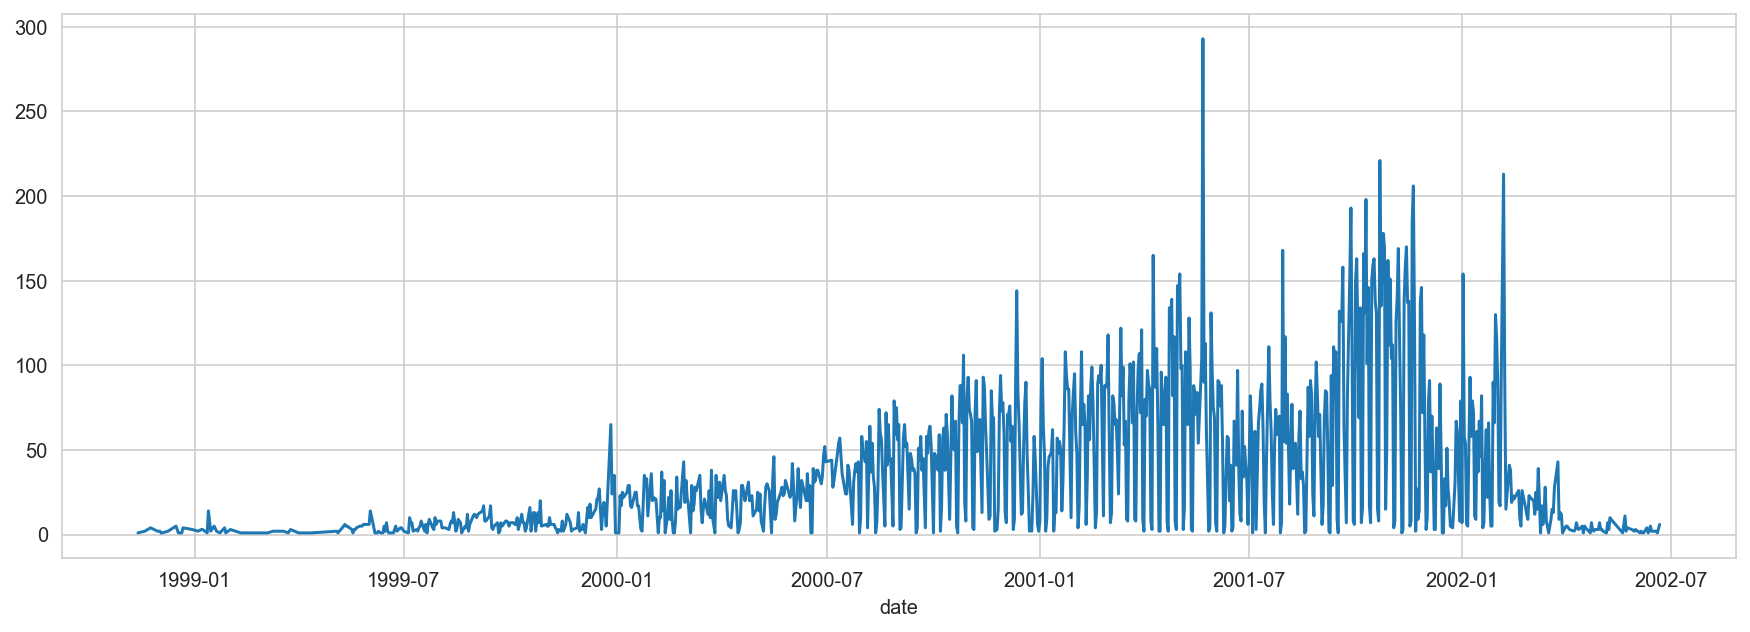

In [6]:
data.groupby('date')['unique_email'].count().plot(figsize=(15,5))

In [7]:
data.drop(columns=['unique_email'], inplace=True)

## Formatting data

Convert timestamp to the format that midas expects: index starting from 1.

In [8]:
timestamp_map = {k: i+1 for i, (k, _) in enumerate(groupby(data['timestamp']))}
data['time_index'] = data['timestamp'].map(timestamp_map)
data.head()

,timestamp,sender,recipient,date,time_index
0,910948020,114,169,1998-11-13,1
1,911477940,114,123,1998-11-19,2
2,911481840,114,123,1998-11-19,3
3,911892180,114,38,1998-11-24,4
4,911892180,114,110,1998-11-24,4


## Time tick as it is: minute

The library produces a single score as the maximum of source node, destination node and the edge. I modified it to produce 3 separate scores to have a more accurate attribution.

In [9]:
scores = midasR(
    data['sender'], data['recipient'], data['time_index'],
    num_rows=2,
    num_buckets=2719,
    factor=0.4,
)
data['minute_src_score'], data['minute_dst_score'], data['minute_edge_score'] = zip(*scores)
data['minute_score'] = data[['minute_src_score', 'minute_dst_score', 'minute_edge_score']].max(axis=1)

100%|██████████| 38131/38131 [00:06<00:00, 5825.38it/s]


### Edge score alone

In [10]:
def plot_score(score_field):
    plt.figure(figsize=(15,5))
    plt.plot(data['date'], data[score_field])

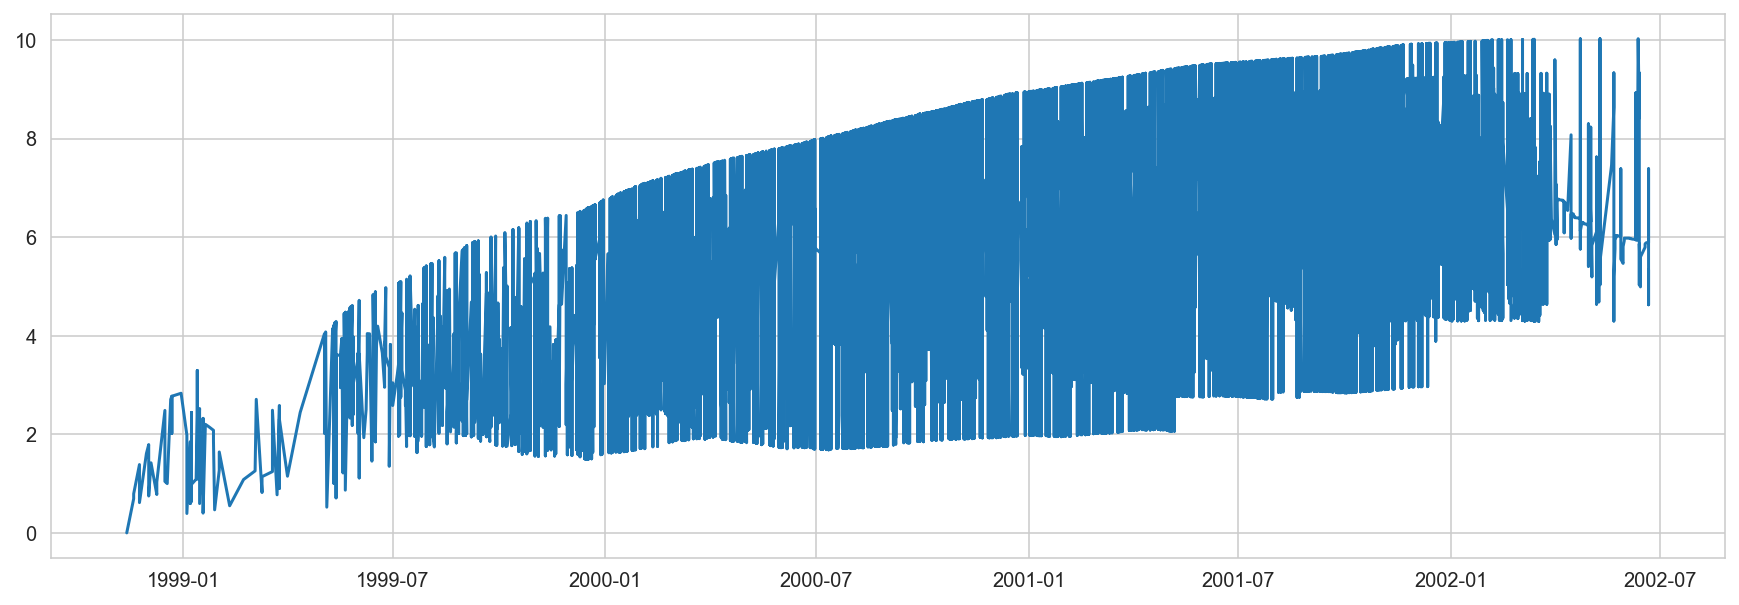

In [11]:
plot_score('minute_edge_score')

Hmm, is it useful? There is a clear artifact of incremental increase of scores. This is probably a linear relationship shown in a log scale. 
- The code shows that multiple edge counts in the same time tick have scores increasingly rather than sharing the same score.
- Also, as time increases the mean getting smaller and 1/mean will just get bigger.
- The keep-increasing is probably due to an edge that never appears before.

This inflated score is probably not useful.

### Source score

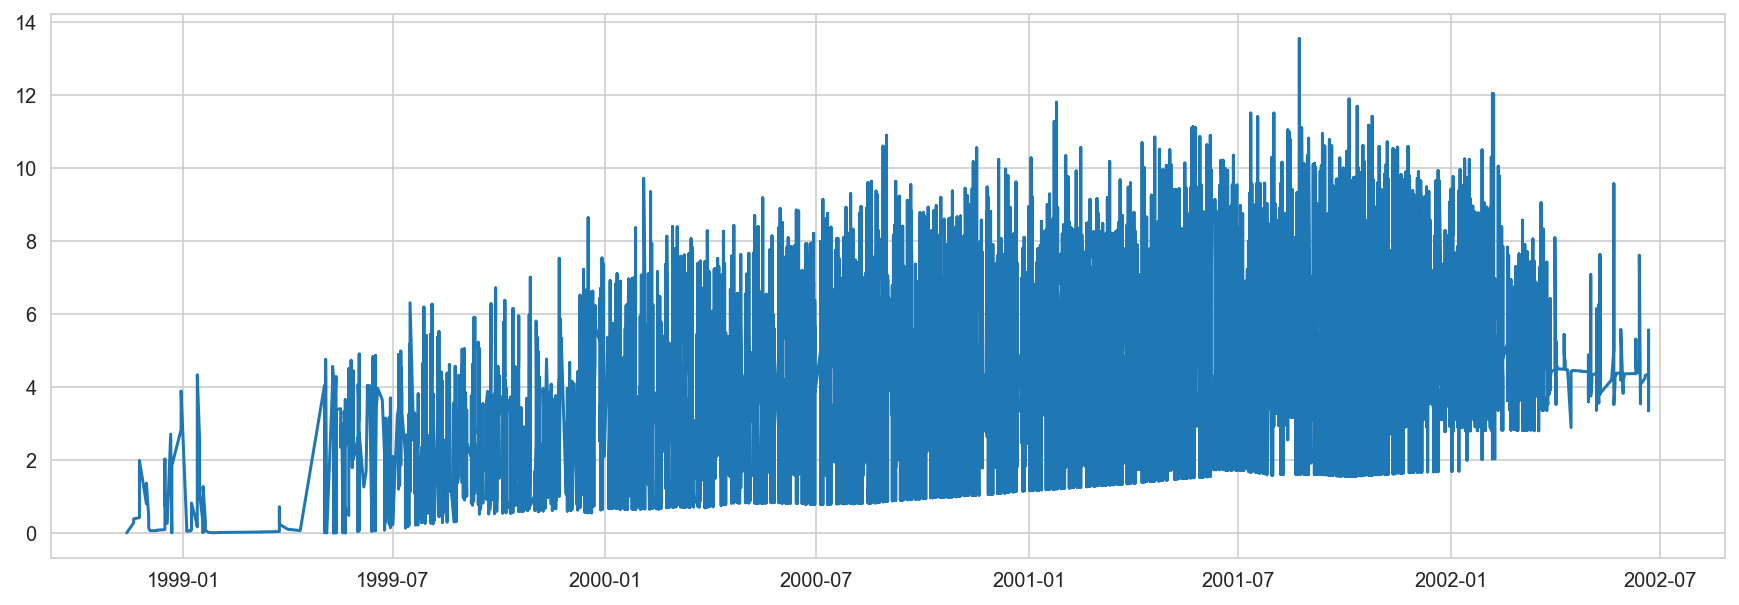

In [12]:
plot_score('minute_src_score')

#### The trend is still going up but much less monotonic. Let's look at cumulative max.

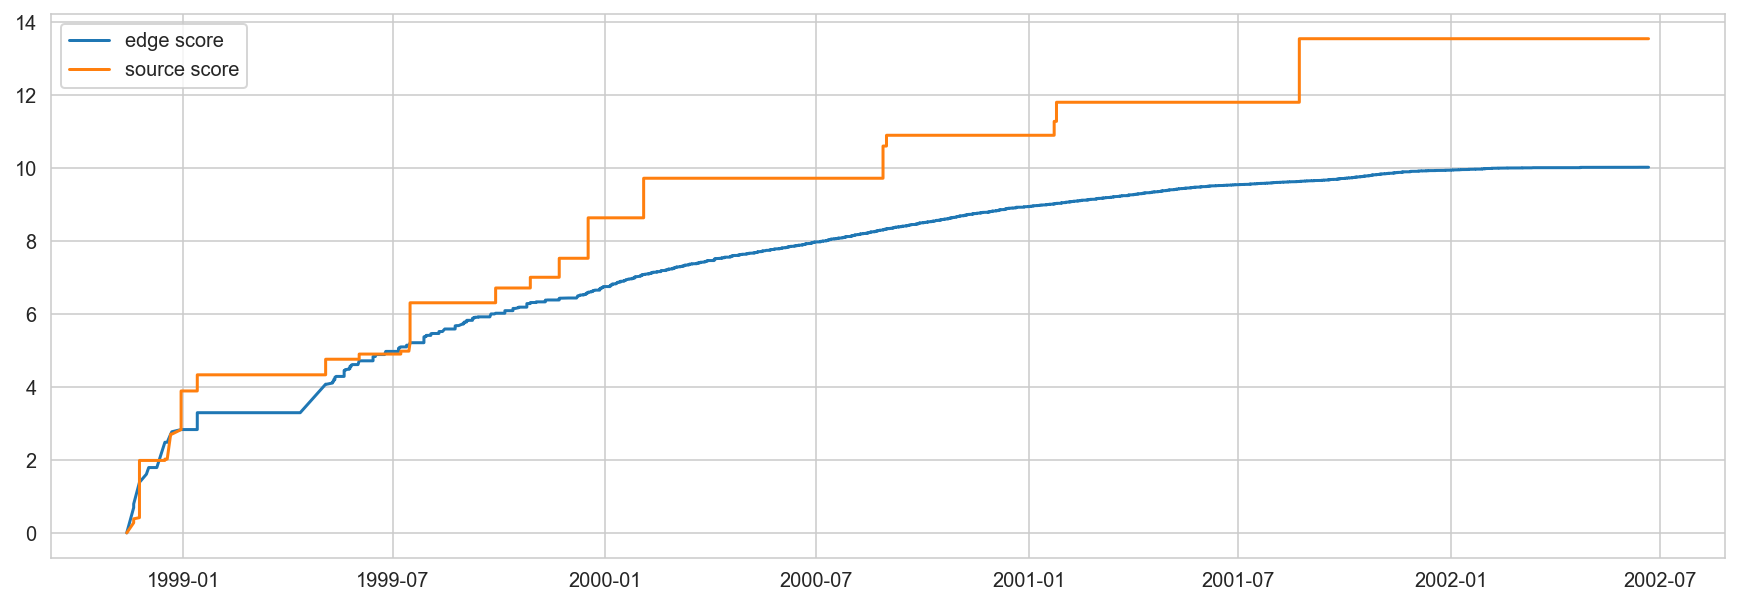

In [13]:
plt.figure(figsize=(15,5))
plt.plot(data['date'], data['minute_edge_score'].cummax())
plt.plot(data['date'], data['minute_src_score'].cummax())
plt.legend(['edge score', 'source score'])
plt.show()

In [14]:
def analyse_cumulative_highscores(score_field):
    logs = []
    highest_score = 0
    previous_time = 0
    for i, d in data.iterrows():
        if d[score_field] > highest_score:
            highest_score = d[score_field]
            
            # Combine same message sent to multiple recipients
            if previous_time == d['timestamp']:
                logs[-1][0].append(highest_score)
                logs[-1][3].append(d.recipient)
            else:
                logs.append(([highest_score], datetime.fromtimestamp(d.timestamp), d.sender, [d.recipient]))
                previous_time = d['timestamp']
                
    for l in logs:
        print(f'[{l[0][0]:5.2f} -> {l[0][-1]:5.2f}]   {l[1]}   {l[2]:3} -> {l[3]}')
            
analyse_cumulative_highscores('minute_src_score')

[ 0.28 ->  0.28]   1998-11-19 12:19:00   114 -> [123]
[ 0.39 ->  0.39]   1998-11-19 13:24:00   114 -> [123]
[ 0.42 ->  1.99]   1998-11-24 07:23:00   114 -> [38, 110, 155, 169]
[ 2.02 ->  2.02]   1998-12-16 06:03:00   114 -> [169]
[ 2.71 ->  2.71]   1998-12-21 10:29:00   123 -> [114]
[ 2.83 ->  3.89]   1998-12-30 10:57:00   112 -> [65, 114, 145]
[ 4.01 ->  4.33]   1999-01-13 11:41:00   114 -> [155, 160, 169]
[ 4.76 ->  4.76]   1999-05-04 07:04:00    38 -> [112]
[ 4.90 ->  4.90]   1999-06-02 06:40:00   169 -> [165]
[ 4.98 ->  4.98]   1999-07-08 12:32:00   107 -> [114]
[ 5.20 ->  5.20]   1999-07-16 07:45:00   165 -> [155]
[ 5.21 ->  6.31]   1999-07-16 12:51:00    29 -> [22, 49, 65]
[ 6.72 ->  6.72]   1999-09-28 03:42:00   146 -> [163]
[ 7.01 ->  7.01]   1999-10-28 08:08:00    63 -> [146]
[ 7.13 ->  7.53]   1999-11-22 07:42:00    58 -> [109, 146]
[ 7.74 ->  8.64]   1999-12-17 13:55:00   153 -> [87, 90, 132, 141, 153, 167]
[ 8.70 ->  9.73]   2000-02-03 18:06:00   105 -> [67, 78, 82, 94, 107

OK, so the highest score is due to employee 94 sends an email to a bunch of people and he/she probably never/rarely sends.

In [15]:
data.query('sender == 94')['date'].value_counts().sort_index()

2001-04-30     1
2001-08-23    51
2001-08-24     4
2001-08-25    18
2001-09-11     1
2001-10-10     1
2001-10-18     2
2001-10-29     1
2001-11-02     3
2001-12-02     1
2001-12-26     1
Name: date, dtype: int64

That's right No.94 only sends one message before on 30-Apr-2001. Who's that?

In [16]:
employees.loc[94]

email      kenneth.lay
name       Kenneth Lay
title              CEO
remarks            NaN
Name: 94, dtype: object

## Daily time tick

In [17]:
timestamp_map = {k: i+1 for i, (k, _) in enumerate(groupby(data['date']))}
data['daily_index'] = data['date'].map(timestamp_map)
data.head()

,timestamp,sender,recipient,date,time_index,minute_src_score,minute_dst_score,minute_edge_score,minute_score,daily_index
0,910948020,114,169,1998-11-13,1,0.000000,0.000000,0.000000,0.000000,1
1,911477940,114,123,1998-11-19,2,0.277632,0.693147,0.693147,0.693147,2
2,911481840,114,123,1998-11-19,3,0.385534,0.792993,0.792993,0.792993,2
3,911892180,114,38,1998-11-24,4,0.418163,1.386294,1.386294,1.386294,3
4,911892180,114,110,1998-11-24,4,1.103180,1.386294,1.386294,1.386294,3


In [18]:
scores = midasR(
    data['sender'], data['recipient'], data['daily_index'],
    num_rows=2,
    num_buckets=2719,
    factor=0.4,
)
data['day_src_score'], data['day_dst_score'], data['day_edge_score'] = zip(*scores)
data['day_score'] = data[['day_src_score', 'day_dst_score', 'day_edge_score']].max(axis=1)

100%|██████████| 38131/38131 [00:06<00:00, 6329.49it/s]


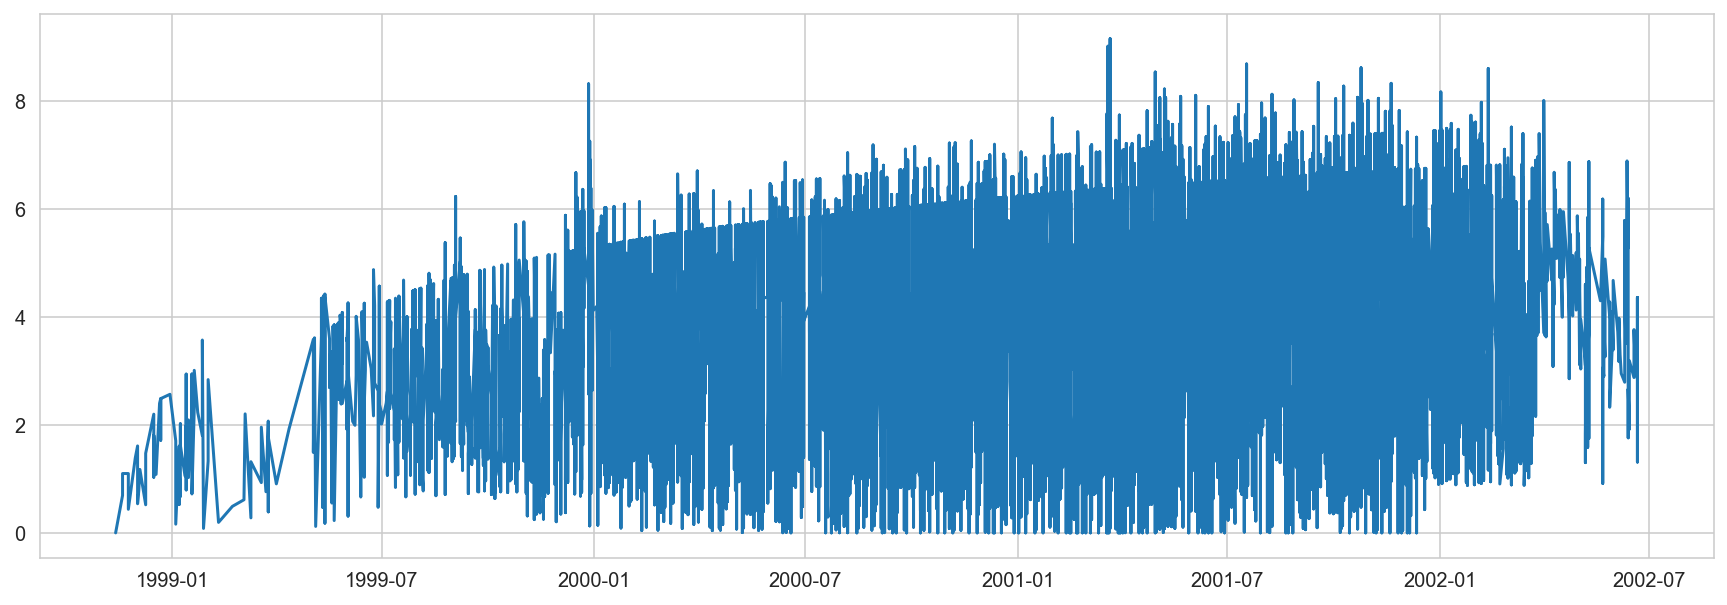

In [19]:
plot_score('day_edge_score')

Look a bit more useful.

In [20]:
analyse_cumulative_highscores('day_edge_score')

[ 0.69 ->  0.69]   1998-11-19 12:19:00   114 -> [123]
[ 1.10 ->  1.10]   1998-11-19 13:24:00   114 -> [123]
[ 1.39 ->  1.39]   1998-11-30 08:22:00   114 -> [65]
[ 1.61 ->  1.61]   1998-12-02 08:47:00   114 -> [145]
[ 2.20 ->  2.20]   1998-12-16 06:03:00   114 -> [11]
[ 2.40 ->  2.40]   1998-12-21 10:29:00   123 -> [114]
[ 2.48 ->  2.48]   1998-12-22 08:44:00   114 -> [22]
[ 2.56 ->  2.56]   1998-12-30 10:57:00   112 -> [65]
[ 2.89 ->  2.94]   1999-01-13 11:41:00   114 -> [29, 145]
[ 2.94 ->  2.94]   1999-01-18 15:25:00   114 -> [155]
[ 3.01 ->  3.01]   1999-01-20 06:38:00   114 -> [155]
[ 3.16 ->  3.16]   1999-01-27 13:03:00   114 -> [155]
[ 3.57 ->  3.57]   1999-01-27 13:20:00   114 -> [155]
[ 3.58 ->  3.58]   1999-05-03 12:00:00    65 -> [38]
[ 3.61 ->  3.61]   1999-05-04 07:04:00    38 -> [65]
[ 3.66 ->  3.66]   1999-05-10 07:06:00   155 -> [114]
[ 4.34 ->  4.34]   1999-05-10 14:22:00   155 -> [114]
[ 4.39 ->  4.39]   1999-05-12 16:36:00   169 -> [114]
[ 4.42 ->  4.42]   1999-05-13 

The highest scores are because they sent to themselves!

#### Plot scores aggregated instead of individual email

Aggregate all mails in a day by taking the maximum score.

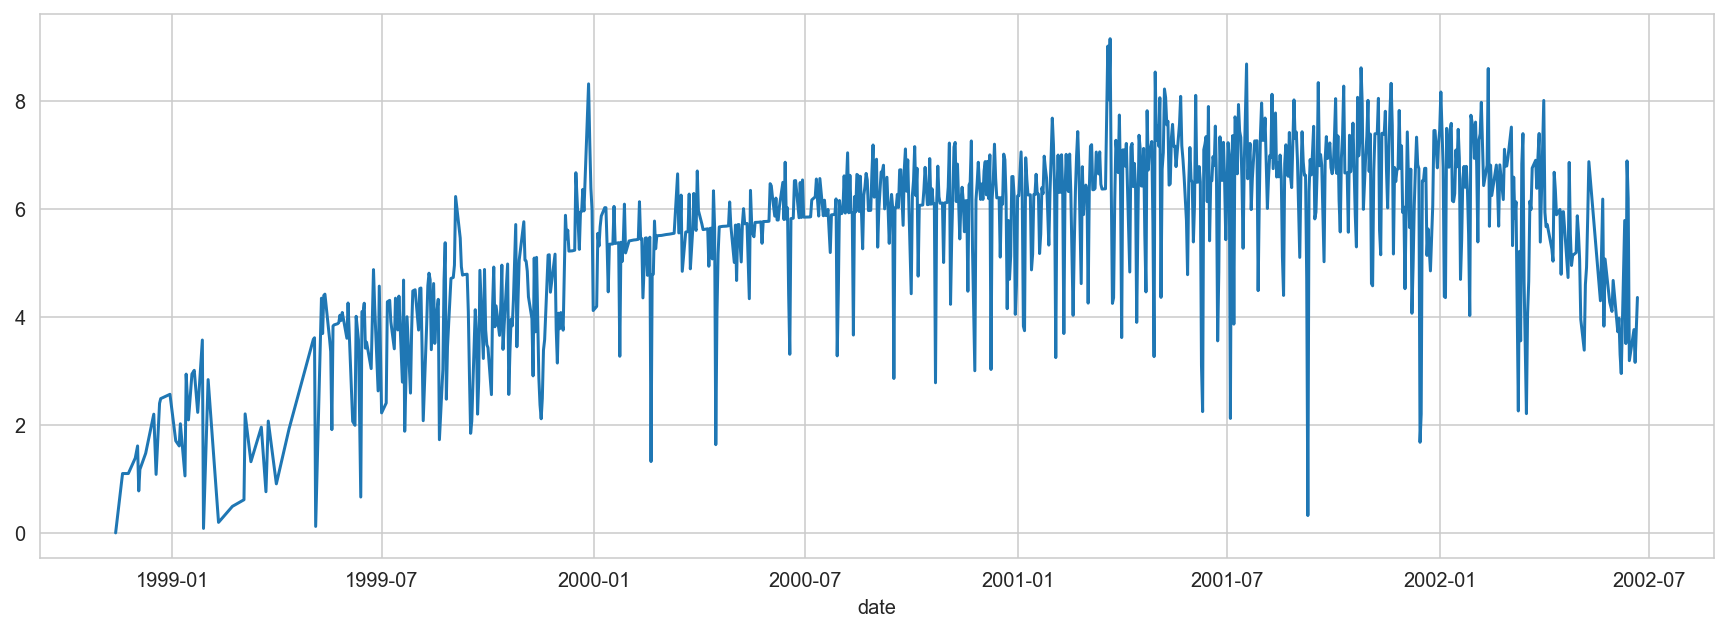

In [21]:
def plot_aggregate(score_field, groupby_field):
    plt.figure(figsize=(15,5))
    data.groupby(groupby_field)[score_field].max().plot()
    
plot_aggregate('day_edge_score', 'date')

## Monthly time tick

In [22]:
data['month'] = data['date'].apply(lambda x: f'{x.year}-{x.month:02}')
timestamp_map = {k: i+1 for i, (k, _) in enumerate(groupby(data['month']))}
data['monthly_index'] = data['month'].map(timestamp_map)
data.head()

,timestamp,sender,recipient,date,time_index,minute_src_score,minute_dst_score,minute_edge_score,minute_score,daily_index,day_src_score,day_dst_score,day_edge_score,day_score,month,monthly_index
0,910948020,114,169,1998-11-13,1,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,0.000000,1998-11,1
1,911477940,114,123,1998-11-19,2,0.277632,0.693147,0.693147,0.693147,2,0.277632,0.693147,0.693147,0.693147,1998-11,1
2,911481840,114,123,1998-11-19,3,0.385534,0.792993,0.792993,0.792993,2,0.732368,1.098612,1.098612,1.098612,1998-11,1
3,911892180,114,38,1998-11-24,4,0.418163,1.386294,1.386294,1.386294,3,0.365892,1.098612,1.098612,1.098612,1998-11,1
4,911892180,114,110,1998-11-24,4,1.103180,1.386294,1.386294,1.386294,3,0.918464,1.098612,1.098612,1.098612,1998-11,1


In [23]:
scores = midasR(
    data['sender'], data['recipient'], data['monthly_index'],
    num_rows=2,
    num_buckets=2719,
    factor=0.4,
)
data['month_src_score'], data['month_dst_score'], data['month_edge_score'] = zip(*scores)
data['month_score'] = data[['month_src_score', 'month_dst_score', 'month_edge_score']].max(axis=1)

100%|██████████| 38131/38131 [00:05<00:00, 7044.71it/s]


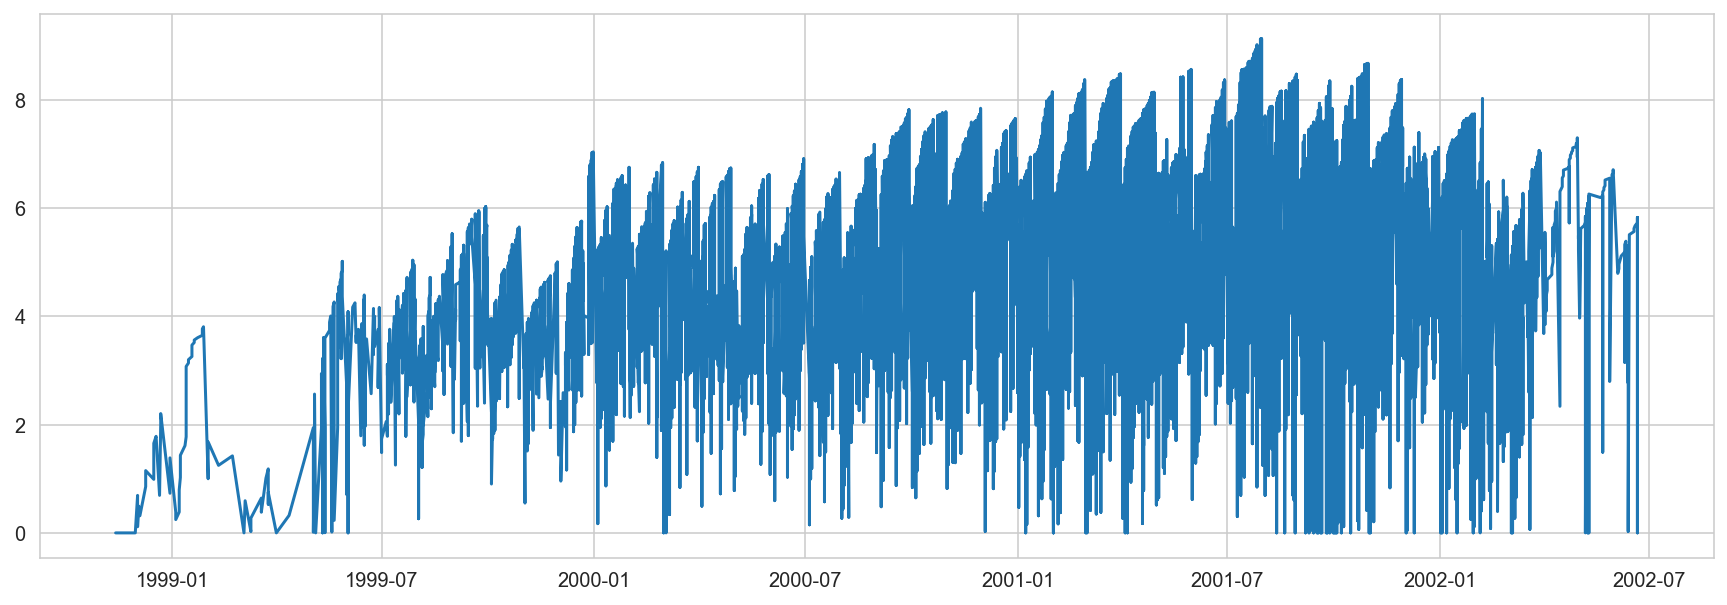

In [24]:
plt.figure(figsize=(15,5))
plt.plot(data['date'], data['month_score'])
plt.show()

OK, seems sensible now. The sloppy artifact is probably due to increasing of score within each month.

In [25]:
analyse_cumulative_highscores('month_score')

[ 0.69 ->  0.69]   1998-12-02 08:47:00   114 -> [145]
[ 0.86 ->  0.86]   1998-12-09 06:14:00   114 -> [169]
[ 1.15 ->  1.15]   1998-12-09 06:17:00   114 -> [169]
[ 1.18 ->  1.51]   1998-12-16 06:03:00   114 -> [110, 155, 169]
[ 1.65 ->  1.65]   1998-12-16 13:35:00   114 -> [169]
[ 1.78 ->  1.78]   1998-12-18 08:02:00   114 -> [169]
[ 1.90 ->  2.20]   1998-12-22 08:44:00   114 -> [22, 65, 112, 160]
[ 2.30 ->  3.07]   1999-01-13 11:41:00   114 -> [38, 50, 65, 110, 112, 123, 145, 155, 160, 169]
[ 3.14 ->  3.14]   1999-01-15 06:20:00   114 -> [155]
[ 3.20 ->  3.20]   1999-01-15 12:22:00   114 -> [169]
[ 3.26 ->  3.26]   1999-01-18 05:28:00   114 -> [155]
[ 3.32 ->  3.32]   1999-01-18 14:56:00   114 -> [38]
[ 3.37 ->  3.47]   1999-01-18 15:25:00   114 -> [110, 155, 169]
[ 3.52 ->  3.52]   1999-01-20 06:37:00   114 -> [155]
[ 3.56 ->  3.56]   1999-01-20 06:38:00   114 -> [155]
[ 3.61 ->  3.61]   1999-01-23 14:01:00   114 -> [155]
[ 3.65 ->  3.65]   1999-01-27 13:01:00   114 -> [155]
[ 3.69 -

## Findings

### CEO

I manage to find out that CEO Kenneth Lay sent an email to a bunch of people on 23-Aug-2001. Probably related to:

> 2001:
>
> Aug. 14 - Skilling resigns; Lay named CEO again.
>
> Aug. 22 - Finance executive Sherron Watkins meets privately with Lay to discuss concerns of murky finance and accounting that could ruin the company.

source: https://www.nytimes.com/2006/01/18/business/worldbusiness/timeline-a-chronology-of-enron-corp.html

### No.9

Employee 9 in the monthly time tick is:

In [26]:
employees.loc[9]

email      bill.williams
name                 xxx
title                NaN
remarks              NaN
Name: 9, dtype: object

He sent quite a lot of emails in the last two weeks of July 2001. I looked it up and found this article analysing his network https://cambridge-intelligence.com/using-social-network-analysis-measures/.

### Comparing with https://arxiv.org/pdf/1901.09688.pdf
That paper reported anomalies in 4 months: Dec-1999, April/May/Aug-2001. The figure below uses daily time tick then aggregates by month and selects the max score in the month.

This also has a local minimum in Dec-1999, May-2001 and the global maximum Aug-2001.

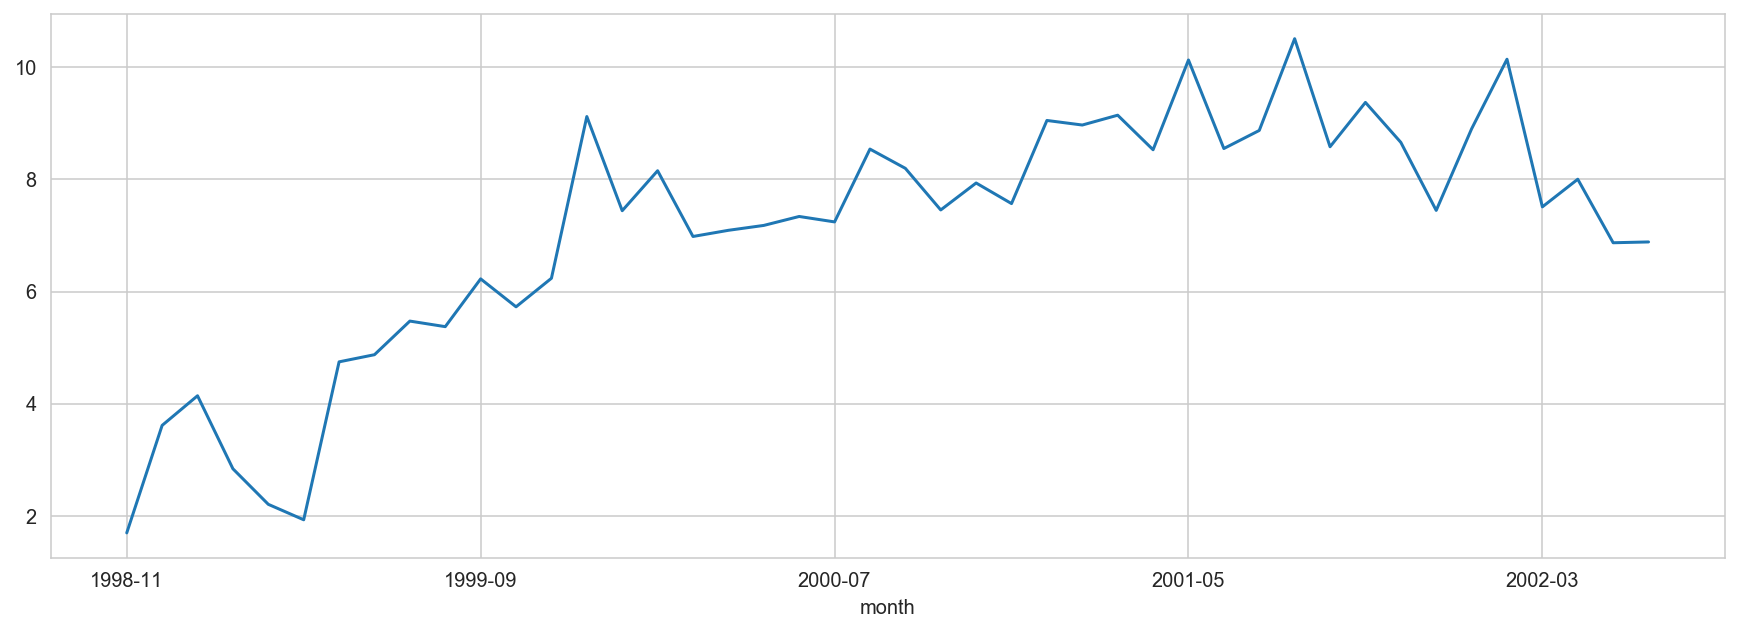

In [27]:
plot_aggregate('day_score', 'month')

> **However, it's not useful for setting a fixed threshold for an event to be anomalous as the scores tend to getting higher over time.**